In [1]:
import os
from time import time
import numpy as np
import sys
sys.path.append('../')

from utils.codification_cnn import CNNLayer, NNLayer, ChromosomeCNN, FitnessCNN, FitnessCNNParallel
from utils.datamanager import DataManager
from utils.codification_skipc import ChromosomeSkip, FitnessSkip, Connections
from GA.parentSelector.parentSelector import RandomParentSelector, TournamentSelection, LinealOrder, WheelSelection
from GA.geneticAlgorithm import GenerationalGA

Using TensorFlow backend.


In [2]:
# Chromosome parameters
NNLayer.possible_activations = ['relu', 'sigmoid', 'tanh', 'elu', 'prelu', 'leakyreLu']
NNLayer.units_lim = 1024

CNNLayer.possible_activations = ['relu', 'sigmoid', 'tanh', 'elu', 'prelu', 'leakyreLu']
CNNLayer.possible_k = [1, 3, 5, 7]
CNNLayer.filters_lim = 128

ChromosomeSkip.max_layers = {'CNN': 10, 'NN': 3}


if os.cpu_count() == 8:
    data_folder = '/home/daniel/datasets/MNIST_variations'
    command = 'python ./../train_gen.py'
    verbose = 1
    gpus = 1
else:
    data_folder = '../../datasets'
    command = 'python3 ./train_gen.py'
    verbose = 0
    gpus = 2



In [3]:
# Set some params

# general parameters
skip = False
experiments_folder = '../../param_sens'


# Fitness params
epochs = 15
batch_size = 128
verbose = verbose
redu_plat = False
early_stop = 15
warm_up_epochs= 0
base_lr = 0.001
smooth = 0.1
cosine_dec = True
lr_find = False
precise_eps = 75

dataset = 'MRDBI'

In [4]:
experiments_folder = experiments_folder
os.makedirs(experiments_folder, exist_ok=True)

if skip:
    fitness_cnn = FitnessSkip()
else:
    fitness_cnn = FitnessCNN()

# dataset params:
data_folder = data_folder
classes = []

exp_folder = os.path.join(experiments_folder, dataset)
fitness_folder = exp_folder
fitness_file = os.path.join(fitness_folder, 'fitness_example')   
os.makedirs(fitness_folder, exist_ok=True)

# Load data
dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder)
data = dm.load_data()

(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples


In [94]:
fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                   epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                   warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                   precise_epochs=precise_eps)

fitness_cnn.save(fitness_file)

In [95]:
fitness = FitnessCNNParallel()
fitness.set_params(chrom_files_folder=fitness_folder, fitness_file=fitness_file, max_gpus=gpus,
                   fp=32, main_line=command)

In [96]:
# Model definition

l1_2 = CNNLayer(86, (3,5), 'leakyreLu', 0.262, 1)
l2_2 = CNNLayer(84, (5,3), 'leakyreLu', 0.319, 1)
l3_2 = CNNLayer(243, (1,3), 'prelu', 0.322, 0)
l4_2 = NNLayer(948, 'sigmoid', 0.467)
l5_2 = NNLayer(780, 'sigmoid', 0.441)
model_gen = ChromosomeCNN([l1_2, l2_2, l3_2], [l4_2, l5_2], fitness)

In [109]:
def force_mutation(chromosome, cnn_activation=None, nn_activation=None, k_size=None, k_mode='same'):
    assert cnn_activation in ['relu', 'sigmoid', 'tanh', 'elu', 'prelu', 'leakyreLu', None]
    assert nn_activation in ['relu', 'sigmoid', 'tanh', 'elu', 'prelu', 'leakyreLu', None]
    assert k_size in [1, 3, 5, 7, None]
    assert k_mode in ['min', 'max', 'same']

    new_chromosome = chromosome.self_copy()
    if cnn_activation is not None:
        for layer in new_chromosome.cnn_layers:
            layer.activation = cnn_activation
            
    if nn_activation is not None:
        for layer in new_chromosome.nn_layers:
            layer.activation = nn_activation
        
    if k_size is not None:
        for layer in new_chromosome.cnn_layers:
            layer.k_size = (k_size, k_size)
            
    if k_mode != 'same':
        for layer in new_chromosome.cnn_layers:
            size_h, size_w = layer.k_size
            new_size = [min(size_h, size_w), max(size_h, size_w)][k_mode == 'max']
            layer.k_size = (new_size, new_size)
            
    return new_chromosome
    
def eval_model(chromosome, N, fitness_function):
    #return [np.random.rand(), np.random.rand()+1, np.random.rand()+2, np.random.rand()+3, np.random.rand()+4]
    ti = time()
    evaluated_fitness = fitness_function.eval_list([chromosome for
                                                    i in range(N)], precise_mode=True, test=True)
    data_val = [data[0] for data in evaluated_fitness]
    data_test = [data[1] for data in evaluated_fitness]
    
    val_mean, val_std, val_best = np.mean(data_val), np.std(data_val), np.min(data_val)
    test_mean, test_std, test_best = np.mean(data_test), np.std(data_test), np.min(data_test)
    tf = (time() - ti) / (gpus * 60)
    return [val_mean, val_std, val_best, test_mean, test_std, test_best, tf]

In [110]:
N_evaluations = 4
print(model_gen)


CNN|F:86|K:(3,5)|A:leakyreLu|D:0.262|M:1
CNN|F:84|K:(5,3)|A:leakyreLu|D:0.319|M:1
CNN|F:243|K:(1,3)|A:prelu|D:0.322|M:0
NN|U:948|A:sigmoid|D:0.467
NN|U:780|A:sigmoid|D:0.441



In [114]:
cnn_relu = force_mutation(model_gen, cnn_activation='relu')
cnn_prelu = force_mutation(model_gen, cnn_activation='prelu')
nn_relu = force_mutation(model_gen, nn_activation='relu')
nn_sigmoid = force_mutation(model_gen, nn_activation='sigmoid')
min_k = force_mutation(model_gen, k_mode='min')
max_k = force_mutation(model_gen, k_mode='max')
k3 = force_mutation(model_gen, k_size=3)

all_models = {'original':model_gen, 'CNN ReLU':cnn_relu, 'CNN PReLU':cnn_prelu,
              'NN ReLU':nn_relu, 'NN sigmoid':nn_sigmoid, 'Min k size':min_k,
              'Max k size':max_k, 'Kernel size 3':k3}

cols = ['Model', 'val mean', 'val_std', 'val best', 'test mean', 'test_std', 'test best', 'time (min)']
results = np.empty(shape=(len(all_models.keys()) + 1, len(cols)), dtype='U20')

for i in range(len(cols)):
    results[0, i] = cols[i]


In [115]:
for k, (model_name, model) in enumerate(all_models.items()):
    print(k, model_name)
    print(model)
    partial_results = [model_name] + eval_model(model, N_evaluations, fitness)
    for j in range(len(partial_results)):
        results[k + 1, j] = partial_results[j]


0 original
CNN|F:86|K:(3,5)|A:leakyreLu|D:0.262|M:1
CNN|F:84|K:(5,3)|A:leakyreLu|D:0.319|M:1
CNN|F:243|K:(1,3)|A:prelu|D:0.322|M:0
NN|U:948|A:sigmoid|D:0.467
NN|U:780|A:sigmoid|D:0.441



KeyboardInterrupt: 

In [103]:
def plot_table(matrix):
    s = ""
    first = True
    for row in matrix:
        s += "|"
        for element in row:
            try:
                s += "%0.4f"% float(element) + "|"
            except ValueError:
                s += element + "|"
        s += "\n"
        if first:
            mid_line = "|"
            for element in row:
                mid_line += "-|"
            mid_line += "\n"
            s += mid_line
            first = False
    return s

print(plot_table(results))

|Model|val mean|val_std|test mean|test_std|time (min)|
|-|-|-|-|-|-|
|original|0.0956|1.3351|2.8524|3.3542|4.6840|
|CNN ReLU|0.6788|1.0949|2.4032|3.9795|4.6815|
|CNN PReLU|0.7750|1.8662|2.5808|3.5690|4.0972|
|NN ReLU|0.7308|1.6096|2.1075|3.2418|4.3219|
|NN sigmoid|0.5799|1.5035|2.0006|3.5963|4.7283|
|Min k size|0.6603|1.8726|2.8220|3.6206|4.2646|
|Max k size|0.9324|1.9131|2.7651|3.6264|4.3868|
|Kernel size 3|0.4361|1.1645|2.4259|3.6228|4.4336|



|Model|val mean|val_std|test mean|test_std|time (min)|
|-|-|-|-|-|-|
|original|0.0956|1.3351|2.8524|3.3542|4.6840|
|CNN ReLU|0.6788|1.0949|2.4032|3.9795|4.6815|
|CNN PReLU|0.7750|1.8662|2.5808|3.5690|4.0972|
|NN ReLU|0.7308|1.6096|2.1075|3.2418|4.3219|
|NN sigmoid|0.5799|1.5035|2.0006|3.5963|4.7283|
|Min k size|0.6603|1.8726|2.8220|3.6206|4.2646|
|Max k size|0.9324|1.9131|2.7651|3.6264|4.3868|
|Kernel size 3|0.4361|1.1645|2.4259|3.6228|4.4336|




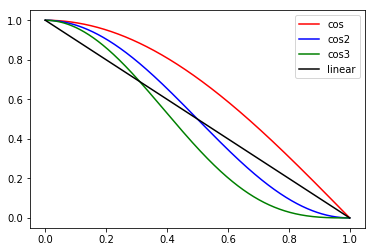

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(0,1,1000)
linear = np.linspace(1, 0, len(x))
cos = np.cos(np.pi * x / 2)
cos2 = cos**2
cos3 = cos**3

plt.plot(x, cos, label='cos', c='r')
plt.plot(x, cos2, label='cos2', c='b')
plt.plot(x, cos3, label='cos3', c='g')
plt.plot(x, linear, label='linear', c='k')
plt.legend()
plt.show()

[]

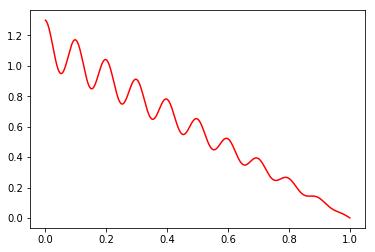

In [13]:
cos_hight = 0.3 * np.cos(np.pi * x * 10)**2
t = linear * cos_hight + linear
plt.plot(x, t, label='cos', c='r')
plt.plot()